In [1]:
# Imports
import time
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from scipy.interpolate import interp1d

from crow import ClusterShearProfile
from crow import ClusterAbundance
from crow.recipes.binned_exact import ExactBinnedClusterRecipe
from crow.recipes.binned_grid import GridBinnedClusterRecipe
from crow import completeness_models, mass_proxy, purity_models, kernel
from crow.properties import ClusterProperty

# Testing the Cluster Abundance and Lensing Recipes

In this tutorial we demonstrate how to use the *cluster abundance* and *cluster weak-lensing* prediction machinery implemented in this package.  
The goal is to benchmark the two available approaches:

- **ExactBinnedClusterRecipe**  
  Performs multi-dimensional integrals using interpolated integrands and numerical quadrature (e.g., `dblquad`).  
  This is the *ground-truth* reference method, typically slower but very accurate.

- **GridBinnedClusterRecipe**  
  Approximates the integrals on pre-computed, structured grids over mass, redshift, and observable (proxy).  
  This method is *much faster* after a one-time setup step and is suitable for large surveys or sampling algorithms.

Throughout this notebook we will:

1. Construct cosmology, halo mass function, and all required selection functions  
2. Build cluster shear models (ΔΣ and reduced shear) in multiple physical configurations  
3. Compare exact vs grid-based predictions for  
   - Cluster number counts  
   - Lensing profiles (ΔΣ or reduced shear)  
4. Explore speed, accuracy, relative differences, and scaling with binning choices  

This notebook should serve both as a **tutorial** and a **performance guide** for users of the cluster recipe framework.

**Important**: Exact recipes use the **Binned** mass richness relation and grid uses the **Unbinned**.

In [2]:
# ---- Core cosmology and HMF (same numbers as your example) ----
hmf = ccl.halos.MassFuncTinker08(mass_def="200c")
cosmo = ccl.Cosmology(
    Omega_c=0.2607,      # Cold dark matter density
    Omega_b=0.04897,     # Baryon density
    h=0.6766,            # Hubble parameter
    sigma8=0.8102,       # Matter fluctuation amplitude
    n_s=0.9665,          # Spectral index
)

# ---- Distributions and survey params used across examples ----
pivot_mass, pivot_redshift = 14.625862906, 0.6
comp_dist = completeness_models.CompletenessAguena16()
pur_dist = purity_models.PurityAguena16()
mass_distribution = mass_proxy.MurataUnbinned(pivot_mass, pivot_redshift)
mass_distribution_binned = mass_proxy.MurataBinned(pivot_mass, pivot_redshift)
redshift_distribution = kernel.SpectroscopicRedshift()

# ---- Common grid / binning parameters for later cells ----
mass_grid_size = 80
redshift_grid_size = 20
proxy_grid_size = 20
sky_area = 440
mass_interval = (12.5, 17.0)
z_bin = (0.2, 0.4)
z_points = np.linspace(z_bin[0], z_bin[1], redshift_grid_size)
proxy_bin = (1.0, 1.3)
proxy_points = np.linspace(proxy_bin[0], proxy_bin[1], proxy_grid_size)
radius_center = np.array([4.0])

# ------------------------------------------------------------------
# Create ClusterShearProfile instances for all requested cases
# ------------------------------------------------------------------

# 1) Delta Sigma (ΔΣ) — default concentration float
cl_deltasigma_default = ClusterShearProfile(cosmo, hmf, 4.0, True)

# 2) Delta Sigma (ΔΣ) — concentration disabled (concentration from pyccl)
cl_deltasigma_no_conc = ClusterShearProfile(cosmo, hmf, None, True)


# 3) Reduced shear — default concentration, no interpolation
cl_reduced_default_no_interp = ClusterShearProfile(cosmo, hmf, 4.0, False, True)
# don't call set_beta_s_interp -> no interpolation
cl_reduced_default_no_interp.set_beta_parameters(10)

# 4) Reduced shear — default concentration, WITH interpolation
cl_reduced_default_interp = ClusterShearProfile(cosmo, hmf, 4.0, False, True)
cl_reduced_default_interp.set_beta_parameters(10)

# 5) cluster abundance
cl_abundandce = ClusterAbundance(cosmo, hmf)



## 2. Testing Cluster Abundance Across Multiple Redshift and Richness Bins

We now extend the previous test by evaluating the cluster abundance predictions over a **grid of bins**:

- **4 redshift bins**
- **4 richness (proxy) bins**

This produces a grid of **16 bin combinations**, and we compute abundances for all four recipe configurations:

1. **Exact** (no completeness)  
2. **Grid** (no completeness)  
3. **Exact** (with completeness)  
4. **Grid** (with completeness)

We then visualize the output abundances using a scatter plot, where each point corresponds to a specific  
$(z_i, \lambda_j)$ bin pair. This test allows us to assess:

- The consistency between exact and grid-based abundance predictions  
- The effect of completeness on the expected counts  
- Bin-to-bin stability of the recipe calculations  

This multi-bin test provides a stronger validation than the single-bin comparison performed earlier.


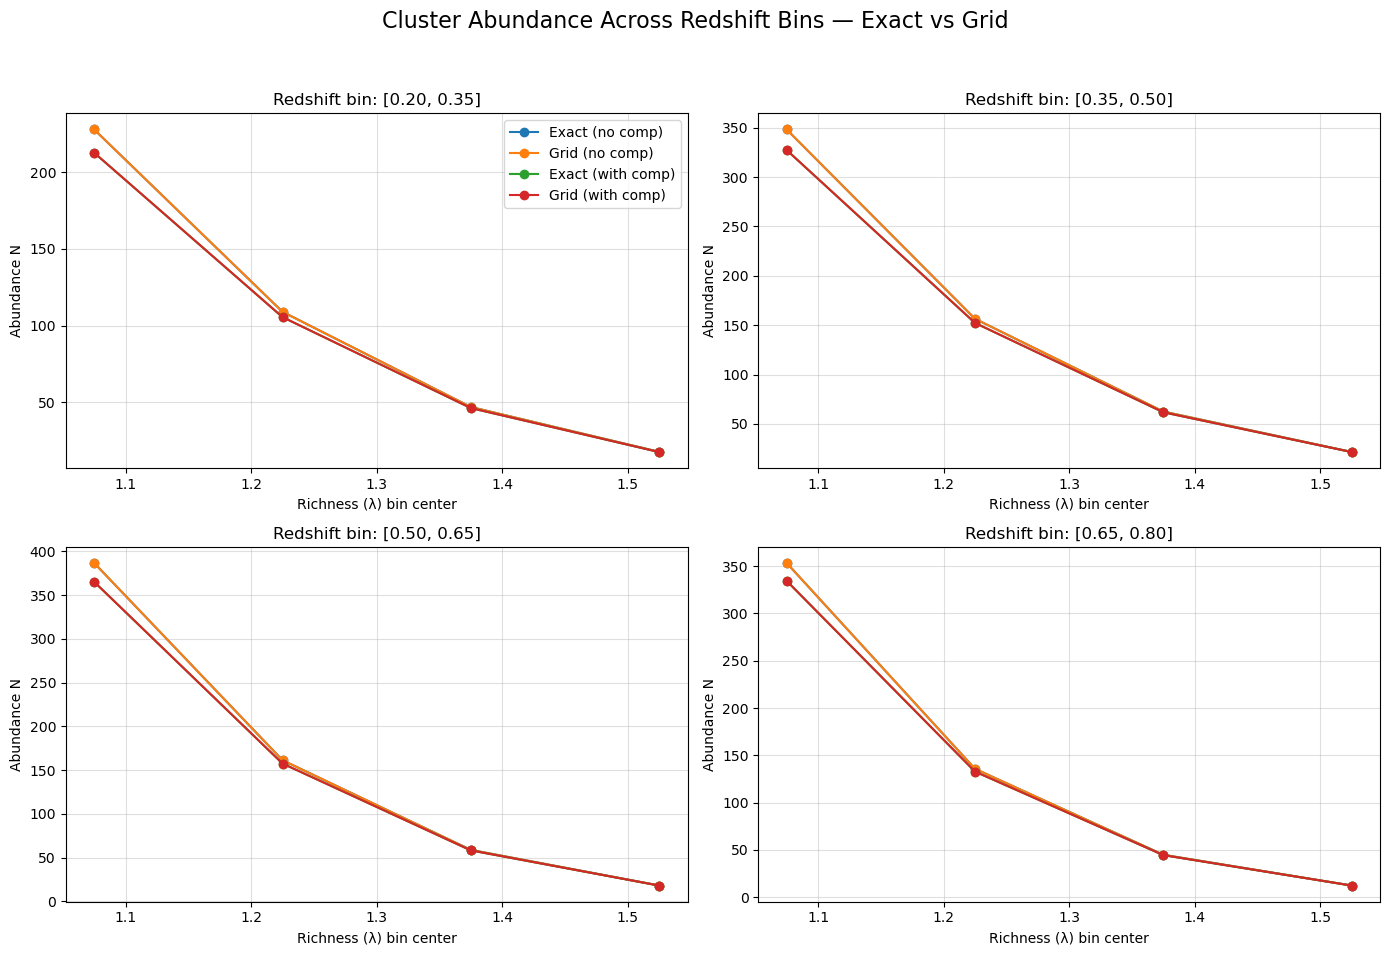

==== Total Computation Time ====
Exact recipes (all 16 bins): 0.273 s
Grid  recipes (all 16 bins): 0.258 s


In [3]:
# ------------------------------------------------------------
# 2. Test: Cluster Abundance — 4 Subplots (one per z-bin)
# ------------------------------------------------------------

from matplotlib import pyplot as plt
import numpy as np
import time

# ------------------------------------------------------------
# Build 4 redshift bins and 4 richness (proxy) bins
# ------------------------------------------------------------

z_edges = np.linspace(0.2, 0.8, 5)    # 4 bins between [0.2, 0.8]
proxy_edges = np.linspace(1.0, 1.6, 5)  # 4 bins between [1.0, 1.6]

z_bins = [(z_edges[i], z_edges[i+1]) for i in range(4)]
proxy_bins = [(proxy_edges[i], proxy_edges[i+1]) for i in range(4)]

# ------------------------------------------------------------
# Construct the 4 abundance recipes
# ------------------------------------------------------------

# NO completeness
recipe_exact_nocomp = ExactBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_abundandce,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_distribution_binned,
)

recipe_grid_nocomp = GridBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_abundandce,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_distribution,
    proxy_grid_size=proxy_grid_size,
    redshift_grid_size=redshift_grid_size,
    mass_grid_size=mass_grid_size,
)
recipe_grid_nocomp.setup()

# WITH completeness
recipe_exact_comp = ExactBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_abundandce,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_distribution_binned,
    completeness=comp_dist,
)

recipe_grid_comp = GridBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_abundandce,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_distribution,
    completeness=comp_dist,
    proxy_grid_size=proxy_grid_size,
    redshift_grid_size=redshift_grid_size,
    mass_grid_size=mass_grid_size,
)
recipe_grid_comp.setup()

# ------------------------------------------------------------
# Evaluate abundances over all z × richness bins, with timing
# ------------------------------------------------------------

exact_t0 = time.time()
exact_nocomp_vals = np.zeros((4,4))
exact_comp_vals   = np.zeros((4,4))

for i, zb in enumerate(z_bins):
    for j, pb in enumerate(proxy_bins):
        exact_nocomp_vals[i,j] = recipe_exact_nocomp.evaluate_theory_prediction_counts(zb, pb, sky_area)
        exact_comp_vals[i,j]   = recipe_exact_comp.evaluate_theory_prediction_counts(zb, pb, sky_area)

exact_total_time = time.time() - exact_t0

grid_t0 = time.time()
grid_nocomp_vals  = np.zeros((4,4))
grid_comp_vals    = np.zeros((4,4))

for i, zb in enumerate(z_bins):
    for j, pb in enumerate(proxy_bins):
        grid_nocomp_vals[i,j]  = recipe_grid_nocomp.evaluate_theory_prediction_counts(zb, pb, sky_area)
        grid_comp_vals[i,j]    = recipe_grid_comp.evaluate_theory_prediction_counts(zb, pb, sky_area)

grid_total_time = time.time() - grid_t0

# ------------------------------------------------------------
# Plot 4 subplots — one per z-bin
# ------------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

richness_centers = [(pb[0] + pb[1]) / 2 for pb in proxy_bins]

for i, ax in enumerate(axes):

    ax.plot(richness_centers, exact_nocomp_vals[i], '-o', label="Exact (no comp)")
    ax.plot(richness_centers, grid_nocomp_vals[i], '-o', label="Grid (no comp)")
    ax.plot(richness_centers, exact_comp_vals[i], '-o', label="Exact (with comp)")
    ax.plot(richness_centers, grid_comp_vals[i], '-o', label="Grid (with comp)")

    ax.set_title(f"Redshift bin: [{z_bins[i][0]:.2f}, {z_bins[i][1]:.2f}]")
    ax.set_xlabel("Richness (λ) bin center")
    ax.set_ylabel("Abundance N")
    ax.grid(alpha=0.4)

# Only show legend once
axes[0].legend()

fig.suptitle("Cluster Abundance Across Redshift Bins — Exact vs Grid", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ------------------------------------------------------------
# Print timing info
# ------------------------------------------------------------

print("==== Total Computation Time ====")
print(f"Exact recipes (all 16 bins): {exact_total_time:.3f} s")
print(f"Grid  recipes (all 16 bins): {grid_total_time:.3f} s")


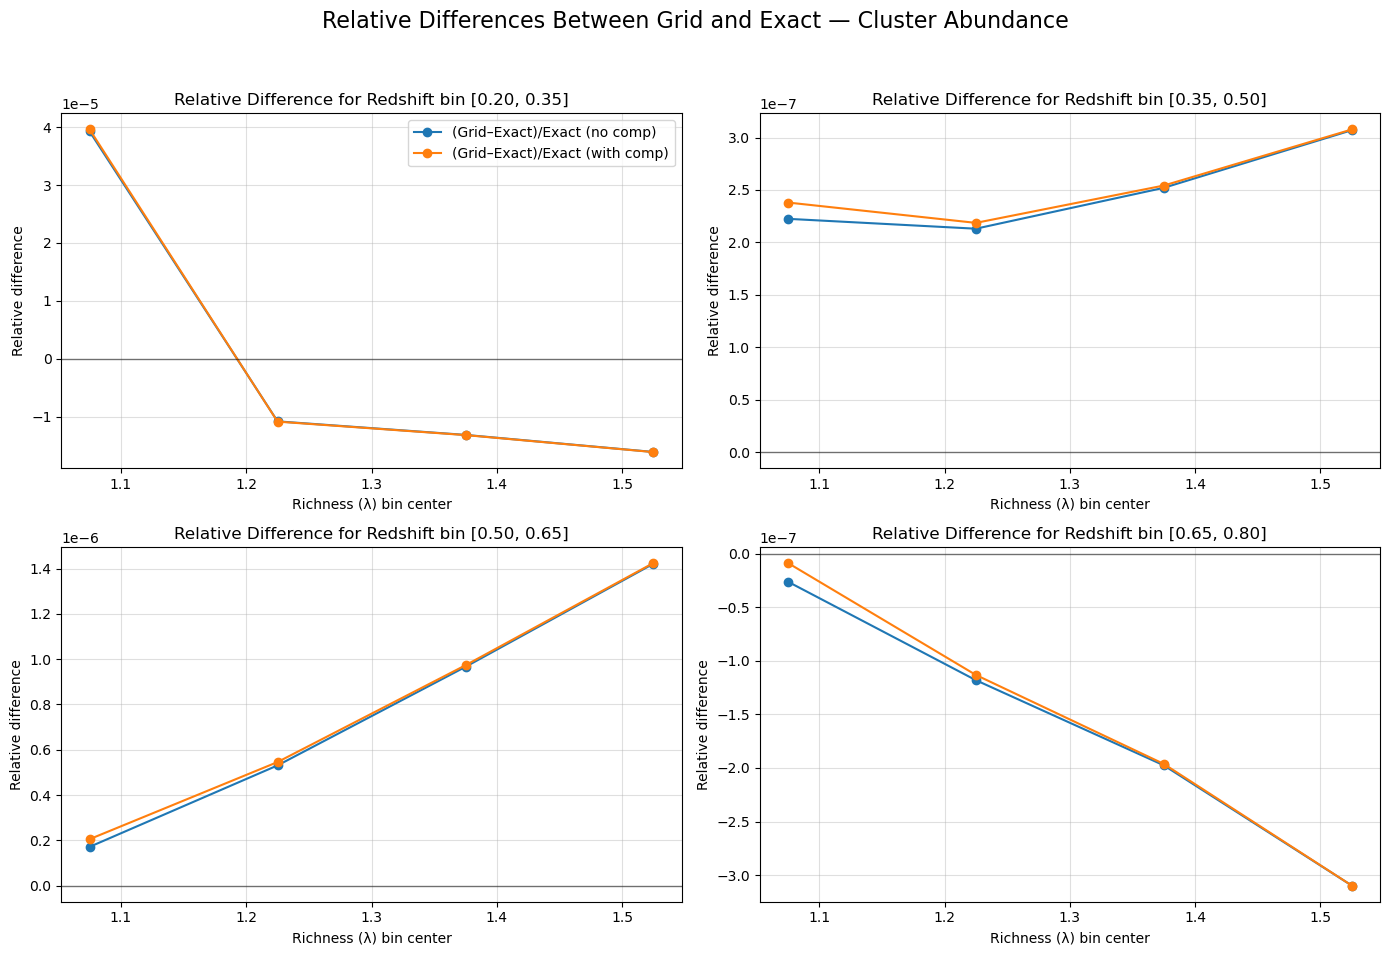

In [4]:
# ------------------------------------------------------------
# 3. Plot relative differences: (Grid - Exact) / Exact
# ------------------------------------------------------------

import numpy as np
from matplotlib import pyplot as plt

# Compute relative differences
reldiff_nocomp = (grid_nocomp_vals - exact_nocomp_vals) / exact_nocomp_vals
reldiff_comp   = (grid_comp_vals   - exact_comp_vals)   / exact_comp_vals

# ------------------------------------------------------------
# Build figure with 4 subplots (one per z-bin)
# ------------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

richness_centers = [(pb[0] + pb[1]) / 2 for pb in proxy_bins]

for i, ax in enumerate(axes):

    ax.plot(richness_centers, reldiff_nocomp[i], '-o', label="(Grid–Exact)/Exact (no comp)")
    ax.plot(richness_centers, reldiff_comp[i],   '-o', label="(Grid–Exact)/Exact (with comp)")

    ax.axhline(0.0, color='k', lw=1, alpha=0.5)
    ax.set_title(f"Relative Difference for Redshift bin [{z_bins[i][0]:.2f}, {z_bins[i][1]:.2f}]")
    ax.set_xlabel("Richness (λ) bin center")
    ax.set_ylabel("Relative difference")
    ax.grid(alpha=0.4)

axes[0].legend()

fig.suptitle("Relative Differences Between Grid and Exact — Cluster Abundance", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 3. Testing Cluster Mean Mass and Redshift Across Multiple Redshift and Richness Bins


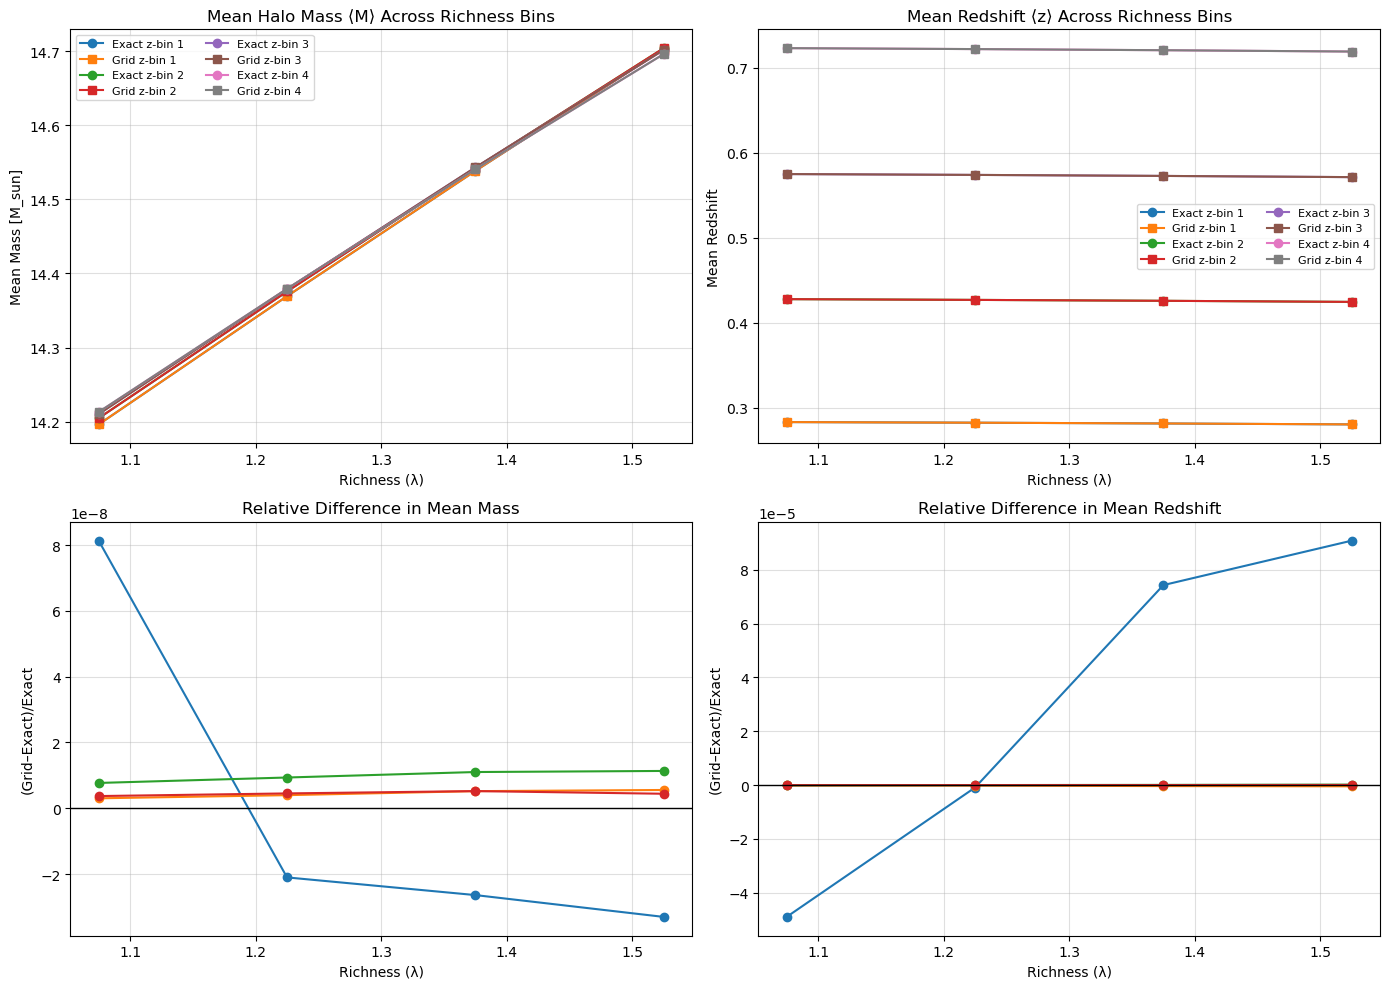

In [5]:
# ------------------------------------------------------------
# 4. Test Mean-Mass and Mean-Redshift Predictions (4×4 bins)
# ------------------------------------------------------------

# Flags for averaging
avg_mass     = ClusterProperty.MASS
avg_redshift = ClusterProperty.REDSHIFT

# Containers
exact_mass_vals = []
grid_mass_vals  = []
exact_z_vals    = []
grid_z_vals     = []

# Also store counts so we can divide!
exact_counts_vals = []
grid_counts_vals  = []

# Loop over bins
for zb in z_bins:
    for pb in proxy_bins:

        # --- counts (needed for means) ---
        exact_counts_vals.append(
            recipe_exact_nocomp.evaluate_theory_prediction_counts(zb, pb, sky_area)
        )
        grid_counts_vals.append(
            recipe_grid_nocomp.evaluate_theory_prediction_counts(zb, pb, sky_area)
        )

        # --- total mass ---
        exact_mass_vals.append(
            recipe_exact_nocomp.evaluate_theory_prediction_counts(zb, pb, sky_area, avg_mass)
        )
        grid_mass_vals.append(
            recipe_grid_nocomp.evaluate_theory_prediction_counts(zb, pb, sky_area, avg_mass)
        )

        # --- total redshift ---
        exact_z_vals.append(
            recipe_exact_nocomp.evaluate_theory_prediction_counts(zb, pb, sky_area, avg_redshift)
        )
        grid_z_vals.append(
            recipe_grid_nocomp.evaluate_theory_prediction_counts(zb, pb, sky_area, avg_redshift)
        )

# Convert to arrays
exact_counts_vals = np.array(exact_counts_vals)
grid_counts_vals  = np.array(grid_counts_vals)

exact_mass_vals = np.array(exact_mass_vals)
grid_mass_vals  = np.array(grid_mass_vals)
exact_z_vals    = np.array(exact_z_vals)
grid_z_vals     = np.array(grid_z_vals)

# ------------------------------------------------------------
# Convert totals → MEANS
# ------------------------------------------------------------
mean_mass_exact = exact_mass_vals / exact_counts_vals
mean_mass_grid  = grid_mass_vals  / grid_counts_vals

mean_z_exact = exact_z_vals / exact_counts_vals
mean_z_grid  = grid_z_vals  / grid_counts_vals

# Reshape into (4 × 4)
mean_mass_exact = mean_mass_exact.reshape(4, 4)
mean_mass_grid  = mean_mass_grid.reshape(4, 4)

mean_z_exact = mean_z_exact.reshape(4, 4)
mean_z_grid  = mean_z_grid.reshape(4, 4)

# Richness centers
richness_centers = [(pb[0] + pb[1]) / 2 for pb in proxy_bins]

# ------------------------------------------------------------
# Make 2×2 figure: means + relative differences
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ---------- Mean Mass ----------
ax = axes[0,0]
for i in range(4):
    ax.plot(richness_centers, mean_mass_exact[i], '-o', label=f"Exact z-bin {i+1}")
    ax.plot(richness_centers, mean_mass_grid[i],  '-s', label=f"Grid z-bin {i+1}")
ax.set_title("Mean Halo Mass ⟨M⟩ Across Richness Bins")
ax.set_xlabel("Richness (λ)")
ax.set_ylabel("Mean Mass [M_sun]")
ax.grid(alpha=0.4)
ax.legend(ncol=2, fontsize=8)

# ---------- Mean Redshift ----------
ax = axes[0,1]
for i in range(4):
    ax.plot(richness_centers, mean_z_exact[i], '-o', label=f"Exact z-bin {i+1}")
    ax.plot(richness_centers, mean_z_grid[i],  '-s', label=f"Grid z-bin {i+1}")
ax.set_title("Mean Redshift ⟨z⟩ Across Richness Bins")
ax.set_xlabel("Richness (λ)")
ax.set_ylabel("Mean Redshift")
ax.grid(alpha=0.4)
ax.legend(ncol=2, fontsize=8)

# ---------- Relative Difference: Mean Mass ----------
ax = axes[1,0]
reldiff_mass = (mean_mass_grid - mean_mass_exact) / mean_mass_exact
for i in range(4):
    ax.plot(richness_centers, reldiff_mass[i], '-o')
ax.axhline(0, color='k', lw=1)
ax.set_title("Relative Difference in Mean Mass")
ax.set_xlabel("Richness (λ)")
ax.set_ylabel("(Grid–Exact)/Exact")
ax.grid(alpha=0.4)

# ---------- Relative Difference: Mean Redshift ----------
ax = axes[1,1]
reldiff_z = (mean_z_grid - mean_z_exact) / mean_z_exact
for i in range(4):
    ax.plot(richness_centers, reldiff_z[i], '-o')
ax.axhline(0, color='k', lw=1)
ax.set_title("Relative Difference in Mean Redshift")
ax.set_xlabel("Richness (λ)")
ax.set_ylabel("(Grid–Exact)/Exact")
ax.grid(alpha=0.4)

plt.tight_layout()
plt.show()


## 4. ΔΣ Exact vs Grid — 3 Radii

This cell compares the predicted **Delta Sigma (ΔΣ)** lensing profile computed with the **ExactBinnedClusterRecipe** and the **GridBinnedClusterRecipe** using three radii: 2, 4, and 6 Mpc. The comparison is done for all redshift and richness bins.

**Procedure:**
1. **Exact computation:**  
   Uses `ExactBinnedClusterRecipe` which evaluates the triple Simpson integral directly for each mass, redshift, and richness bin.

2. **Grid computation:**  
   Uses `GridBinnedClusterRecipe` with precomputed grids for the halo mass function, mass-richness relation, and shear profile.  
   The grids are set up by calling `setup()` before the evaluation.

3. **Normalization:**  
   After computing the total ΔΣ in each bin, the values are divided by the predicted counts to obtain the **mean ΔΣ per cluster**.

4. **Relative differences:**  
   The fractional difference between the grid and exact calculations is computed as  
   \[
   \text{reldiff} = \frac{\langle \Delta\Sigma \rangle_\text{grid} - \langle \Delta\Sigma \rangle_\text{exact}}{\langle \Delta\Sigma \rangle_\text{exact}}
   \]

**Important Note:**
Although the `setup()` method resets all the dictionaries in the recipe, the **halo mass function (`cluster_theory.mass_function`) may internally cache values**. If the same cosmology is used and some points were already computed, the subsequent evaluations will be faster because the cached results are reused. This explains why the computation time for the grid is typically faster on the second run.

**Plots:**
- Top: ΔΣ for each redshift bin and radius, comparing Exact vs Grid.
- Bottom: Relative differences between Grid and Exact ΔΣ for each bin and radius.

**Computation Times:**  
Displayed in the figure title for both Exact and Grid evaluations.


{} {} {}


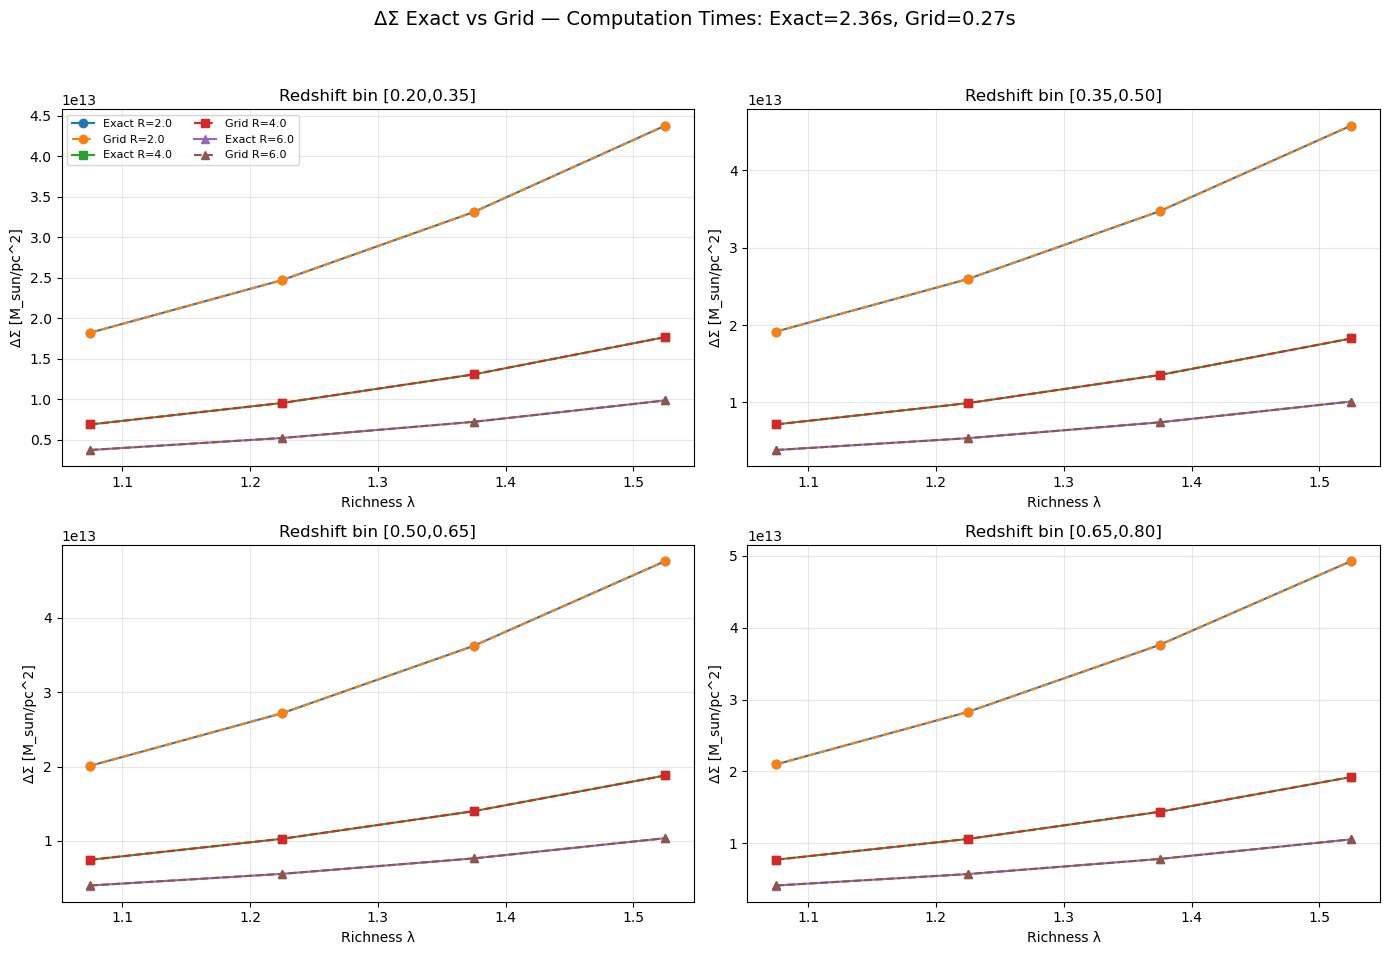

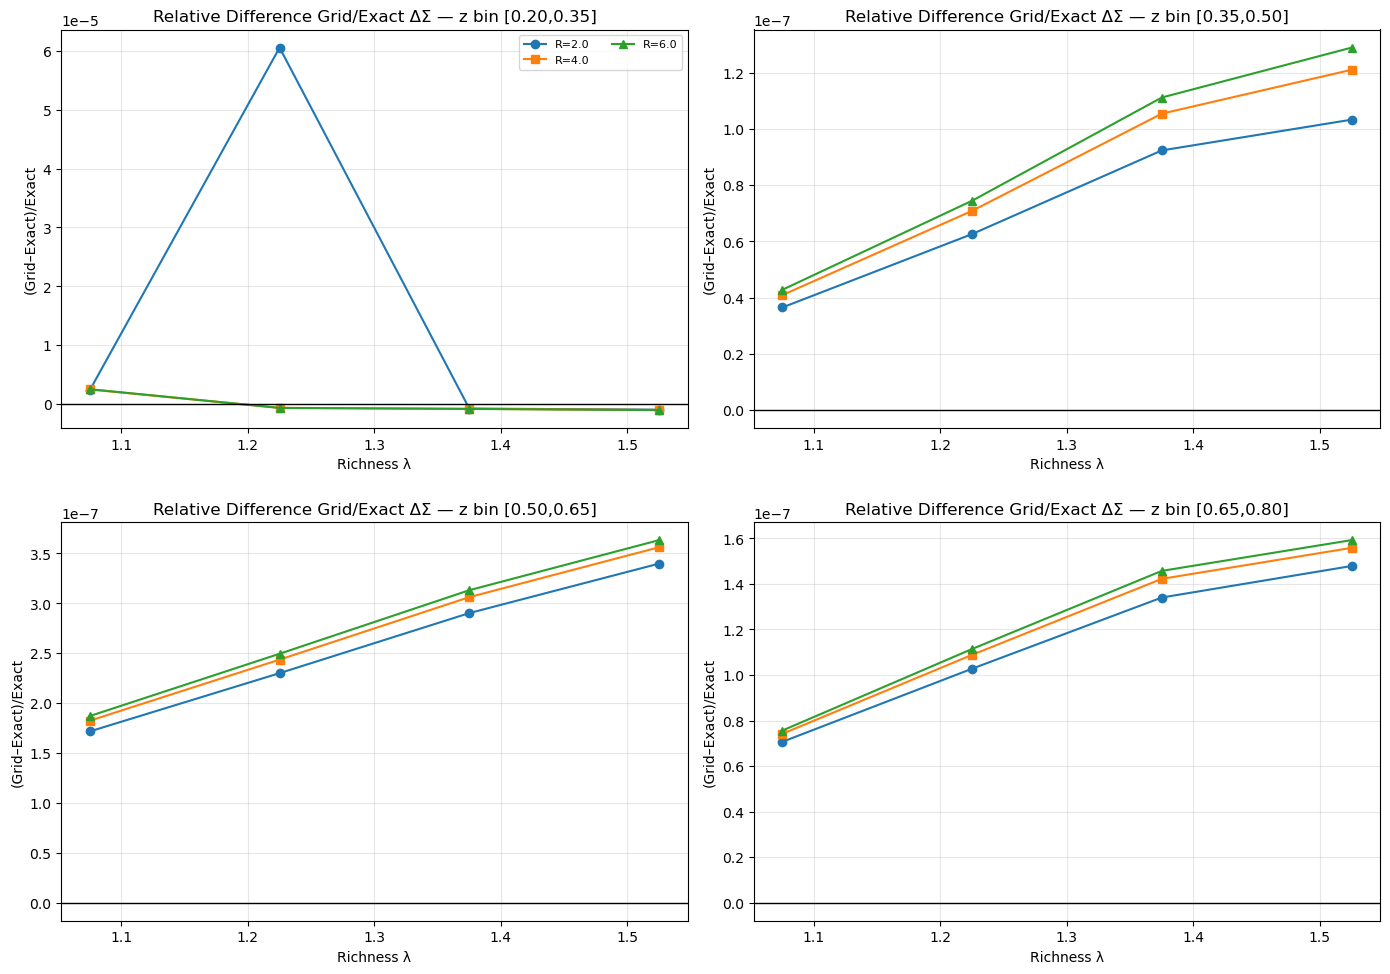

In [6]:
###################### IMPORTANT ######################################
#Note that although the setup cleans all the dictonaries of the recipe, the halo mass function also has their dictionary. If the cosmology is the same and you already computed some points, it will still have these values saved and the time will be faster
cosmo = ccl.Cosmology(
    Omega_c=0.2607,      # Cold dark matter density
    Omega_b=0.04897,     # Baryon density
    h=0.6766,            # Hubble parameter
    sigma8=0.8102,       # Matter fluctuation amplitude
    n_s=0.9665,          # Spectral index
)
cl_deltasigma_default.cosmo = cosmo

#############################################################
recipe_exact_deltasigma = ExactBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_deltasigma_default,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_distribution_binned,
)

recipe_grid_deltasigma = GridBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_deltasigma_default,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_distribution,
    proxy_grid_size=proxy_grid_size,
    redshift_grid_size=redshift_grid_size,
    mass_grid_size=mass_grid_size,
)
recipe_grid_deltasigma.setup()
# ------------------------------------------------------------
# 5a. ΔΣ — Exact vs Grid (3 radius centers)
# ------------------------------------------------------------
average_on_shear = ClusterProperty.DELTASIGMA
radius_centers = np.array([2.0, 4.0, 6.0])  # 3 radii

n_r = len(radius_centers)

# Containers: shape (4 z bins, 4 proxy bins, n_radii)
delta_sigma_exact = np.zeros((4,4,n_r))
delta_sigma_grid  = np.zeros((4,4,n_r))
counts_exact      = np.zeros((4,4))
counts_grid       = np.zeros((4,4))

# ---- Compute ΔΣ for all bins and radii with timing ----
import time

t0 = time.time()
for i, zb in enumerate(z_bins):
    for j, pb in enumerate(proxy_bins):
        counts_exact[i,j] = recipe_exact_deltasigma.evaluate_theory_prediction_counts(zb, pb, sky_area)
        delta_sigma_exact[i,j,:] = recipe_exact_deltasigma.evaluate_theory_prediction_lensing_profile(
            zb, pb, radius_centers, sky_area, average_on_shear
        )
t1 = time.time()
exact_time = t1 - t0

t0 = time.time()
recipe_grid_deltasigma.setup()
print(recipe_grid_deltasigma._shear_grids, recipe_grid_deltasigma._mass_richness_grid, recipe_grid_deltasigma._hmf_grid)
for i, zb in enumerate(z_bins):
    for j, pb in enumerate(proxy_bins):
        counts_grid[i,j] = recipe_grid_deltasigma.evaluate_theory_prediction_counts(zb, pb, sky_area)
        delta_sigma_grid[i,j,:] = recipe_grid_deltasigma.evaluate_theory_prediction_lensing_profile(
            zb, pb, radius_centers, sky_area, average_on_shear
        )
t1 = time.time()
grid_time = t1 - t0

# ---- Compute mean ΔΣ per cluster ----
mean_delta_sigma_exact = delta_sigma_exact / counts_exact[:,:,None]
mean_delta_sigma_grid  = delta_sigma_grid  / counts_grid[:,:,None]

# Relative differences
reldiff_delta_sigma = (mean_delta_sigma_grid - mean_delta_sigma_exact) / mean_delta_sigma_exact

# ------------------------------------------------------------
# Plot ΔΣ for each z bin, 3 radii
# ------------------------------------------------------------
richness_centers = [(pb[0]+pb[1])/2 for pb in proxy_bins]

fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()

markers = ['o','s','^']

for i, ax in enumerate(axes):
    for k, r in enumerate(radius_centers):
        ax.plot(richness_centers, mean_delta_sigma_exact[i,:,k], f'-{markers[k]}', label=f'Exact R={r}')
        ax.plot(richness_centers, mean_delta_sigma_grid[i,:,k], f'--{markers[k]}', label=f'Grid R={r}')
    ax.set_title(f"Redshift bin [{z_bins[i][0]:.2f},{z_bins[i][1]:.2f}]")
    ax.set_xlabel("Richness λ")
    ax.set_ylabel("ΔΣ [M_sun/pc^2]")
    ax.grid(alpha=0.3)
axes[0].legend(ncol=2, fontsize=8)
fig.suptitle(f"ΔΣ Exact vs Grid — Computation Times: Exact={exact_time:.2f}s, Grid={grid_time:.2f}s", fontsize=14)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

# ------------------------------------------------------------
# Relative differences ΔΣ
# ------------------------------------------------------------
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    for k, r in enumerate(radius_centers):
        ax.plot(richness_centers, reldiff_delta_sigma[i,:,k], f'-{markers[k]}', label=f'R={r}')
    ax.axhline(0, color='k', lw=1)
    ax.set_title(f"Relative Difference Grid/Exact ΔΣ — z bin [{z_bins[i][0]:.2f},{z_bins[i][1]:.2f}]")
    ax.set_xlabel("Richness λ")
    ax.set_ylabel("(Grid–Exact)/Exact")
    ax.grid(alpha=0.3)
axes[0].legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


### 5. Reduced Shear Predictions Across Multiple Radii

In this section, we compute the **reduced shear** profiles for clusters using three different approaches:

1. **Exact integration** using `ExactBinnedClusterRecipe`.
2. **Grid-based evaluation without interpolation** using `GridBinnedClusterRecipe`.
3. **Grid-based evaluation with interpolation** in the source redshift distribution.

We compute the reduced shear at **three different radius centers** (`R = 2, 4, 6 Mpc`) for all 4×4 bins of redshift and richness. After computing the shear profiles, we normalize by the predicted counts in each bin to obtain the **mean reduced shear per cluster**.  

Two figures are shown:

- **Top figure:** Absolute reduced shear values for each radius and redshift bin, comparing Exact vs Grid (NoInterp/Interp).
- **Bottom figure:** Relative differences between Grid and Exact, \((\mathrm{Grid}-\mathrm{Exact})/\mathrm{Exact}\), for each radius and redshift bin.

The **total computation time** for all bins is recorded for each method and reported in the figure title, demonstrating the performance gains of the grid-based approach, especially when interpolation is used.


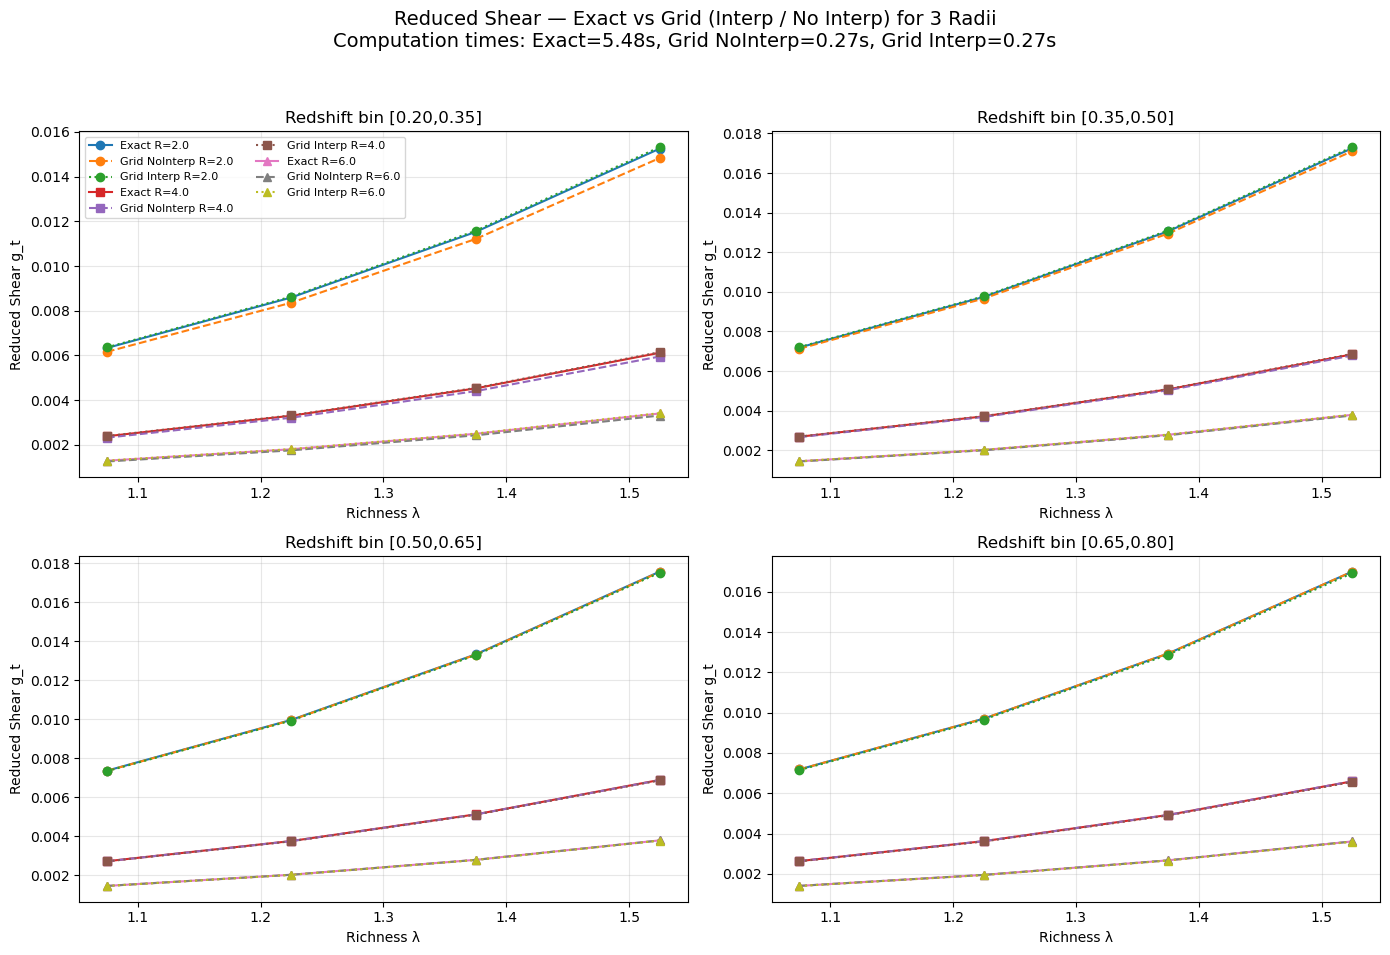

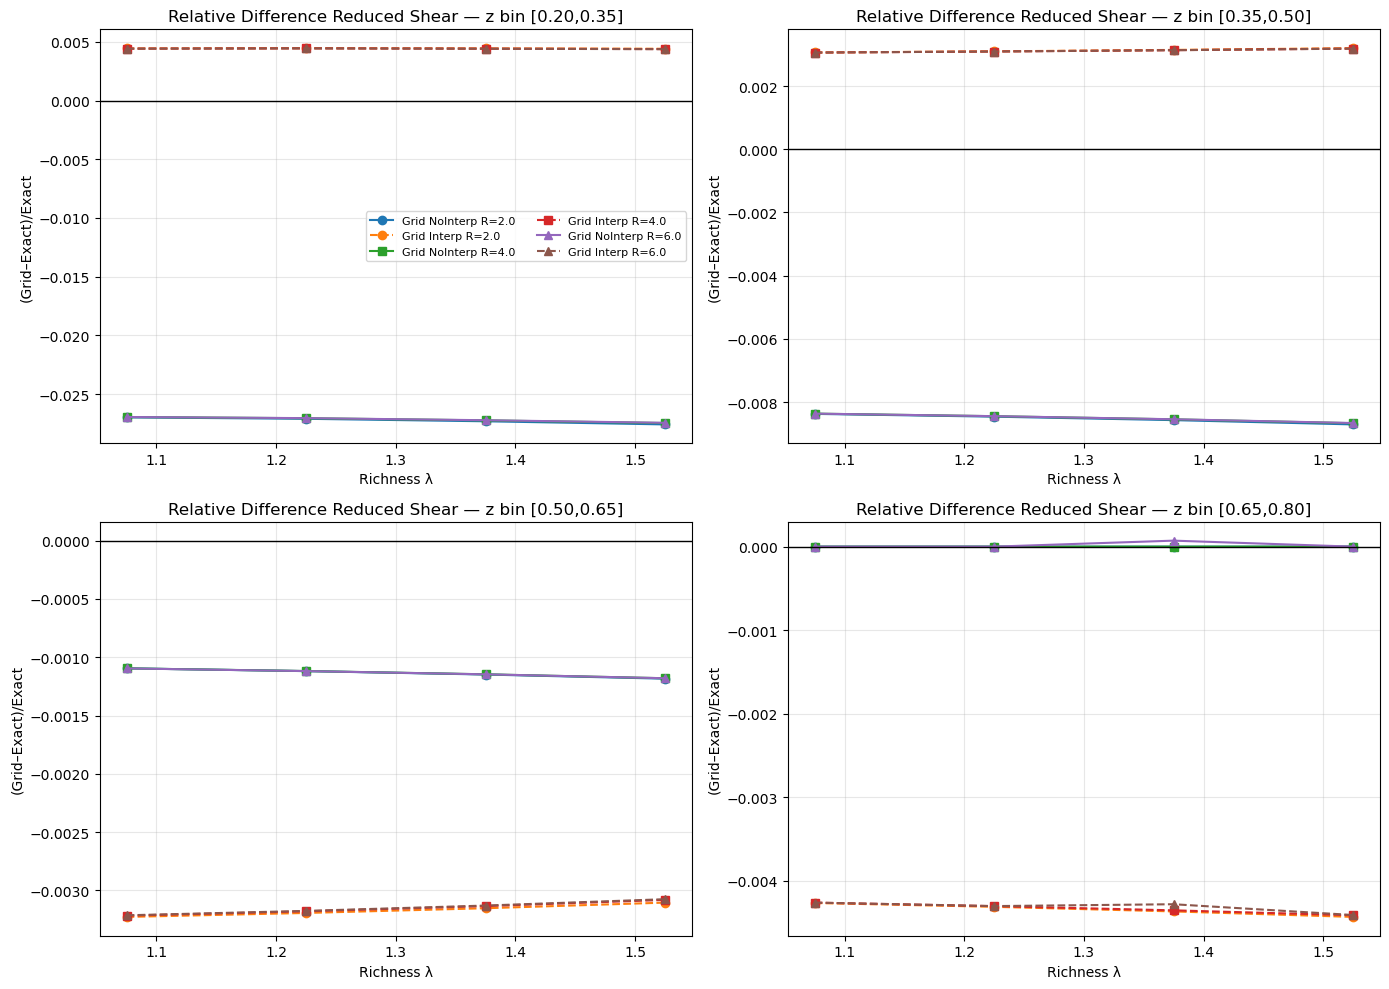

In [7]:
average_on_shear = ClusterProperty.SHEAR

# Recipes
recipe_exact_rs = ExactBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_reduced_default_no_interp,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_distribution_binned,
)

recipe_grid_rs_no_interp = GridBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_reduced_default_no_interp,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_distribution,
    proxy_grid_size=proxy_grid_size,
    redshift_grid_size=redshift_grid_size,
    mass_grid_size=mass_grid_size,
)
recipe_grid_rs_no_interp.setup()
cl_reduced_default_interp.set_beta_s_interp(z_bins[0][0], z_bins[-1][1])
recipe_grid_rs_interp = GridBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_reduced_default_interp,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_distribution,
    proxy_grid_size=proxy_grid_size,
    redshift_grid_size=redshift_grid_size,
    mass_grid_size=mass_grid_size,
)
recipe_grid_rs_interp.setup()


# ------------------------------------------------------------
# 5b. Reduced Shear — 3 radii
# ------------------------------------------------------------
average_on_shear = ClusterProperty.DELTASIGMA
radius_centers = np.array([2.0, 4.0, 6.0])
n_r = len(radius_centers)

# Containers: shape (4 z bins, 4 proxy bins, n_radii)
rs_exact = np.zeros((4,4,n_r))
rs_grid_no_interp = np.zeros((4,4,n_r))
rs_grid_interp = np.zeros((4,4,n_r))
counts_exact = np.zeros((4,4))
counts_grid_no_interp = np.zeros((4,4))
counts_grid_interp = np.zeros((4,4))

t0 = time.time()
for i, zb in enumerate(z_bins):
    for j, pb in enumerate(proxy_bins):
        counts_exact[i,j] = recipe_exact_rs.evaluate_theory_prediction_counts(zb,pb,sky_area)
        rs_exact[i,j,:] = recipe_exact_rs.evaluate_theory_prediction_lensing_profile(
            zb,pb,radius_centers,sky_area,average_on_shear
        )
t1 = time.time()
exact_time = t1 - t0

# ---- Compute Grid NoInterp ----
t0 = time.time()
for i, zb in enumerate(z_bins):
    for j, pb in enumerate(proxy_bins):
        counts_grid_no_interp[i,j] = recipe_grid_rs_no_interp.evaluate_theory_prediction_counts(zb,pb,sky_area)
        rs_grid_no_interp[i,j,:] = recipe_grid_rs_no_interp.evaluate_theory_prediction_lensing_profile(
            zb,pb,radius_centers,sky_area,average_on_shear
        )
t1 = time.time()
grid_no_interp_time = t1 - t0

# ---- Compute Grid Interp ----
t0 = time.time()
for i, zb in enumerate(z_bins):
    for j, pb in enumerate(proxy_bins):
        counts_grid_interp[i,j] = recipe_grid_rs_interp.evaluate_theory_prediction_counts(zb,pb,sky_area)
        rs_grid_interp[i,j,:] = recipe_grid_rs_interp.evaluate_theory_prediction_lensing_profile(
            zb,pb,radius_centers,sky_area,average_on_shear
        )
t1 = time.time()
grid_interp_time = t1 - t0

# Divide by counts
mean_rs_exact = rs_exact / counts_exact[:,:,None]
mean_rs_grid_no_interp = rs_grid_no_interp / counts_grid_no_interp[:,:,None]
mean_rs_grid_interp    = rs_grid_interp / counts_grid_interp[:,:,None]

# Relative differences
reldiff_rs_no_interp = (mean_rs_grid_no_interp - mean_rs_exact)/mean_rs_exact
reldiff_rs_interp    = (mean_rs_grid_interp - mean_rs_exact)/mean_rs_exact

# ------------------------------------------------------------
# Plot Reduced Shear for each z bin, 3 radii
# ------------------------------------------------------------
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()
markers = ['o','s','^']

for i, ax in enumerate(axes):
    for k, r in enumerate(radius_centers):
        ax.plot(richness_centers, mean_rs_exact[i,:,k], f'-{markers[k]}', label=f'Exact R={r}')
        ax.plot(richness_centers, mean_rs_grid_no_interp[i,:,k], f'--{markers[k]}', label=f'Grid NoInterp R={r}')
        ax.plot(richness_centers, mean_rs_grid_interp[i,:,k], f':{markers[k]}', label=f'Grid Interp R={r}')
    ax.set_title(f"Redshift bin [{z_bins[i][0]:.2f},{z_bins[i][1]:.2f}]")
    ax.set_xlabel("Richness λ")
    ax.set_ylabel("Reduced Shear g_t")
    ax.grid(alpha=0.3)
axes[0].legend(ncol=2, fontsize=8)
fig.suptitle(
    f"Reduced Shear — Exact vs Grid (Interp / No Interp) for 3 Radii\n"
    f"Computation times: Exact={exact_time:.2f}s, Grid NoInterp={grid_no_interp_time:.2f}s, Grid Interp={grid_interp_time:.2f}s",
    fontsize=14
)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

# ------------------------------------------------------------
# Plot relative differences
# ------------------------------------------------------------
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    for k, r in enumerate(radius_centers):
        ax.plot(richness_centers, reldiff_rs_no_interp[i,:,k], f'-{markers[k]}', label=f'Grid NoInterp R={r}')
        ax.plot(richness_centers, reldiff_rs_interp[i,:,k], f'--{markers[k]}', label=f'Grid Interp R={r}')
    ax.axhline(0,color='k',lw=1)
    ax.set_title(f"Relative Difference Reduced Shear — z bin [{z_bins[i][0]:.2f},{z_bins[i][1]:.2f}]")
    ax.set_xlabel("Richness λ")
    ax.set_ylabel("(Grid–Exact)/Exact")
    ax.grid(alpha=0.3)
axes[0].legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

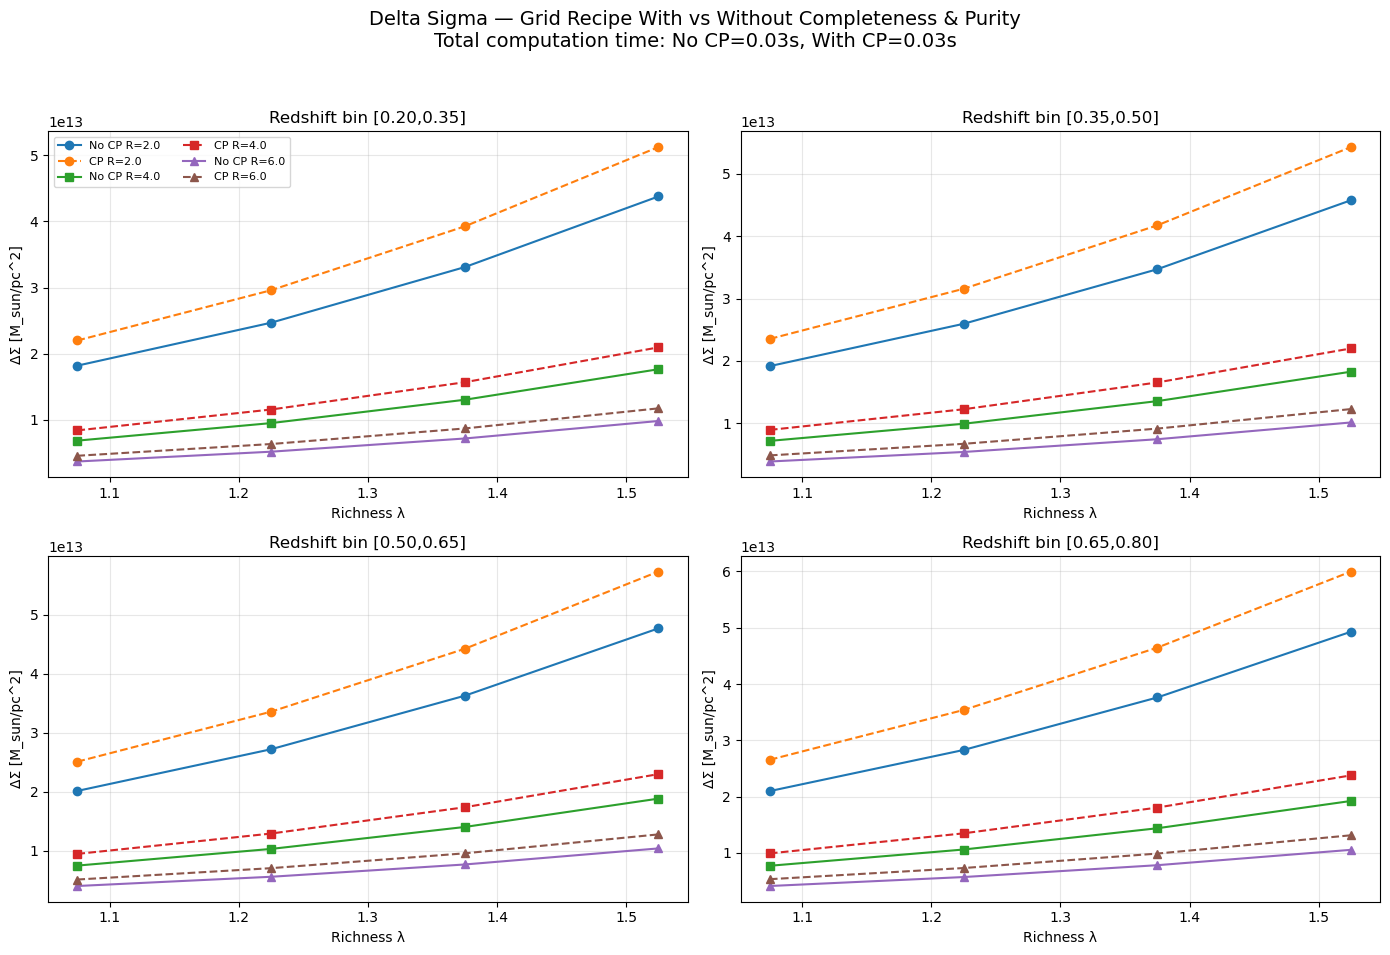

In [8]:
# ------------------------------------------------------------
# 6. Delta Sigma: Grid Recipe With vs Without Completeness & Purity
# ------------------------------------------------------------
average_on_shear = ClusterProperty.DELTASIGMA
radius_centers = np.array([2.0, 4.0, 6.0])
n_r = len(radius_centers)
# ---- Modify completeness and purity parameters by ~20% ----
comp_dist.parameters["a_n"]        = 0.38 * 1.2         # +20%
comp_dist.parameters["b_n"]        = 1.2634 * 0.8       # -20%
comp_dist.parameters["a_logm_piv"] = 13.31 * 1.15       # +15%
comp_dist.parameters["b_logm_piv"] = 0.2025 * 0.85      # -15%

pur_dist.parameters["a_n"]         = 3.9193 * 0.8       # -20%
pur_dist.parameters["b_n"]         = -0.3323 * 1.2      # +20%
pur_dist.parameters["a_logm_piv"]  = 1.1839 * 0.85      # -15%
pur_dist.parameters["b_logm_piv"]  = -0.4077 * 1.2      # +20%

# ---- Recipes ----
# Without completeness/purity
recipe_grid_no_cp = GridBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_deltasigma_default,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_distribution,
    proxy_grid_size=proxy_grid_size,
    redshift_grid_size=redshift_grid_size,
    mass_grid_size=mass_grid_size,
)

# With completeness and purity
recipe_grid_cp = GridBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_deltasigma_default,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_distribution,
    completeness=comp_dist,
    purity=pur_dist,
    proxy_grid_size=proxy_grid_size,
    redshift_grid_size=redshift_grid_size,
    mass_grid_size=mass_grid_size,
)
recipe_grid_no_cp.setup() 
recipe_grid_cp.setup()
# ---- Containers ----
ds_no_cp = np.zeros((4,4,n_r))
ds_cp    = np.zeros((4,4,n_r))
counts_no_cp = np.zeros((4,4))
counts_cp    = np.zeros((4,4))

# ---- Compute values and times ----
t0 = time.time()
for i, zb in enumerate(z_bins):
    for j, pb in enumerate(proxy_bins):
        counts_no_cp[i,j] = recipe_grid_no_cp.evaluate_theory_prediction_counts(zb, pb, sky_area)
        ds_no_cp[i,j,:] = recipe_grid_no_cp.evaluate_theory_prediction_lensing_profile(
            zb, pb, radius_centers, sky_area, average_on_shear
        )
t1 = time.time()
time_no_cp = t1 - t0

t0 = time.time()
for i, zb in enumerate(z_bins):
    for j, pb in enumerate(proxy_bins):
        counts_cp[i,j] = recipe_grid_cp.evaluate_theory_prediction_counts(zb, pb, sky_area)
        ds_cp[i,j,:] = recipe_grid_cp.evaluate_theory_prediction_lensing_profile(
            zb, pb, radius_centers, sky_area, average_on_shear
        )
t1 = time.time()
time_cp = t1 - t0

# ---- Normalize by counts ----
mean_ds_no_cp = ds_no_cp / counts_no_cp[:,:,None]
mean_ds_cp    = ds_cp / counts_cp[:,:,None]

# ---- Plot ----
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()
markers = ['o','s','^']
proxy_centers = np.array([(pb[0] + pb[1]) / 2 for pb in proxy_bins])
for i, ax in enumerate(axes):
    for k, r in enumerate(radius_centers):
        ax.plot(proxy_centers, mean_ds_no_cp[i,:,k], f'-{markers[k]}', label=f'No CP R={r}')
        ax.plot(proxy_centers, mean_ds_cp[i,:,k], f'--{markers[k]}', label=f'CP R={r}')
    ax.set_title(f"Redshift bin [{z_bins[i][0]:.2f},{z_bins[i][1]:.2f}]")
    ax.set_xlabel("Richness λ")
    ax.set_ylabel("ΔΣ [M_sun/pc^2]")
    ax.grid(alpha=0.3)

axes[0].legend(ncol=2, fontsize=8)
fig.suptitle(
    f"Delta Sigma — Grid Recipe With vs Without Completeness & Purity\n"
    f"Total computation time: No CP={time_no_cp:.2f}s, With CP={time_cp:.2f}s",
    fontsize=14
)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()
